In [12]:
import scanpy as sc
import pandas as pd
import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
from importlib import reload  
import helper
reload(helper)
import helper as h
import anndata as ann
import json
import numpy as np

In [2]:
path_latent='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/scArches/integrate_combine_individual/run_scArches1603792372.695119/'
raw_file='data_normlisedForIntegration.h5ad'
path_ref='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/ref_combined/preprocessed/'
path_save='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'

In [3]:
# Individual study data paths
data_study=[
  ('Fltp_2y','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islets_aged_fltp_iCre/rev6/'),
  ('Fltp_adult','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/'),
  ('Fltp_P16','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/'),
  ('NOD','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE144471/'),
  ('NOD_elimination','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE117770/'),
  ('spikein_drug','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465/'),
  ('embryo','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE132188/rev7/'),
  ('VSG','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/'),
  ('STZ','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/')
 ]
data_ref={
    'VSG':('VSG_ref','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/ref/'),
    'STZ': ('STZ_ref','/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/ref/'),
}

## Load data

In [4]:
latent_adata=sc.read(path_latent+'latent.h5ad')
# Remove any ref/nonref info from index
latent_adata.obs_names=[idx.replace('-ref','').replace('-nonref','').replace('_ref','').replace('_nonref','')
                        for idx in latent_adata.obs_names]

In [5]:
latent_adata

AnnData object with n_obs × n_vars = 301796 × 15
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [8]:
genes_anno=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/genomeAnno_ORG'+\
    'mus_musculus_V103.tsv',index_col=0)

In [15]:
genes_anno['gene_symbol_original_matched']=genes_anno[
    [col for col in genes_anno if 'gene_symbol_' in col]
].fillna('NA').apply(lambda x: x.unique()[0] if x.nunique()==1 else np.nan, axis=1)

In [16]:
(~genes_anno['gene_symbol_original_matched'].isna()).sum()

29951

In [7]:
adatas=[]
for study,path in data_study:
    print(study)
    #Load data
    adata=sc.read(path+raw_file)
    print(adata.shape)
    
    # Add gene anno
    genes_anno_temp=genes_anno.copy()
    genes_anno_temp.index=genes_anno_temp['gene_symbol_'+study]
    # Anno raw data
    adata_raw=adata.raw.to_adata()
    # Subset to genes with EIDs before adding EIDs
    print('Missing var:',[var for var in adata_raw.var_names if var not in  genes_anno_temp.index])
    have_EID=[var for var in adata_raw.var_names if var in  genes_anno_temp.index]
    adata_raw=adata_raw[:,have_EID].copy()
    adata_raw.var_names=genes_anno_temp.loc[have_EID,'EID'].copy()
    adata.raw=adata_raw
    # Annon non-raw data
    have_EID=[var for var in adata.var_names if var in  genes_anno_temp.index]
    # Subset to genes with EIDs (e.g. drop custom anno) before adding EIDs
    adata=adata[:,have_EID].copy()
    adata.var_names=genes_anno_temp.loc[have_EID,'EID'].copy()
    
     # Add metadata from annotation
    anno=sc.read_h5ad(path+'data_annotated.h5ad',backed='r').obs.copy()
    # Add additional anno
    for col in ['S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 
                'g1_cyclone',  'sex','pre_cell_type',
                'ins_score','ins_high','gcg_score','gcg_high',
               'sst_score','sst_high','ppy_score','ppy_high']:
        # Can not add other cell types here as some of them are in ref data (STZ/VSG) and not combined one
         if col in anno.columns:
            adata.obs[col]=anno.loc[adata.obs_names,col]

    # Add metadata from metadata file
    metadata=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
                          sheet_name=study.replace('_ref','').replace('_nonref',''))
    samples=adata.obs.file.unique()
    for col in ['cell_filtering','sex','age','design','strain','tissue','technique','internal_id']:
        #Do not add metadata that is already in adata - otherwise sex would be overwritten where it was annotated
        if col in metadata.columns and col not in adata.obs.columns:
            value_map={sample:metadata.query('sample_name =="'+sample+'"')[col].values[0] for sample in samples}
            adata.obs[col]=adata.obs.file.map(value_map)
    
    # Do not save n cells as this changed due to cell filtering
    adata.var.drop([col for col in adatal.var.columns if 'n_cells' in col],axis=1,inplace=True)
    
    adatas.append(adata)
del adata
del adata_raw

# Combine datasets    
adata_full = ann.AnnData.concatenate( *adatas,  
                                     batch_categories = [d[0] for d in data_study ]).copy()
# Edit obs_names to match reference
# Only _ref, _nonref (not "-") is needed here as "-study_ref/nonref" is added to obs names
adata_full.obs_names=[name.replace('_ref','').replace('_nonref','') 
                      for name in adata_full.obs_names]
# Remove any ref/nonref info from study col
adata_full.obs.study=[study.replace('_ref','').replace('_nonref','') 
                      for study in adata_full.obs.study]
# Add gene symbols
adata_full.var['gene_symbol']=genes_anno.loc[adata_full.var_names,'Gene name'].copy()
adata_full.raw.var['gene_symbol']=genes_anno.loc[adata_full.raw.var_names,'Gene name'].copy()
adata_full.var['gene_symbol_original_matched']=genes_anno.loc[
    adata_full.var_names,'gene_symbol_original_matched'].copy()
adata_full.raw.var['gene_symbol_original_matched']=genes_anno.loc[
    adata_full.raw.var_names,'gene_symbol_original_matched'].copy()

Fltp_2y
(17361, 17146)
Missing var: ['eGFP_plus', 'eGFP_minus', 'Td-Tomato-plus', 'Td-Tomato-minus']
Fltp_adult
(17353, 16430)
Missing var: ['venus_construct_plus', 'venus_construct_minus']
Fltp_P16
(19881, 16773)
Missing var: ['eGFP_plus', 'eGFP_minus', 'Td-Tomato-plus', 'Td-Tomato-minus']
NOD
(2690, 15034)
Missing var: ['ngn3_plus', 'ngn3_minus', 'pdx_plus', 'pdx_minus']
NOD_elimination
(54329, 18696)
Missing var: ['ngn3_plus', 'ngn3_minus', 'pdx_plus', 'pdx_minus']
spikein_drug
(33331, 17709)
Missing var: ['ngn3_plus', 'ngn3_minus', 'pdx_plus', 'pdx_minus']
embryo
(37561, 17631)
Missing var: ['ngn3_plus', 'ngn3_minus', 'pdx_plus', 'pdx_minus']
VSG
(69745, 20130)
Missing var: []
STZ
(49545, 18004)
Missing var: []


## Add info

In [8]:
# Add integrated latent space to adata
adata_full.obsm['X_integrated']=latent_adata[adata_full.obs_names,:].X
# Add embedding info from latent to adata
adata_full.uns['neighbors']=latent_adata.uns['neighbors']
adata_full.uns['umap']=latent_adata.uns['umap']
adata_full.obsm['X_umap']=latent_adata.obsm['X_umap']
adata_full.obsp['connectivities']=latent_adata.obsp['connectivities']
adata_full.obsp['distances']=latent_adata.obsp['distances']

In [9]:
# Add design info to column for UMAP titles
# Make col with study and design info
adata_full.obs['study_sample_design']=[study_sample+'_'+str(design) for study_sample, design in 
                                         zip(adata_full.obs.study_sample,adata_full.obs.design)]

In [10]:
# Add refernce cell type information
anno_ref=sc.read_h5ad(path_ref+'data_normalised.h5ad',backed='r')

# Unify latent cell types with current annotation in original data
cell_type_cols=['cell_type','cell_type_multiplet','cell_subtype','cell_subtype_multiplet']
adata_full.obs.drop([col for col in cell_type_cols if col in adata_full.obs.columns],
                    axis=1,inplace=True)
for col in cell_type_cols:
    adata_full.obs.loc[:,col]=anno_ref.obs.reindex(adata_full.obs.index)[col]

In [11]:
# Fill all nan in str and categorical columns with "NA" for plotting
for col in adata_full.obs.columns:
    if adata_full.obs[col].isna().any() and adata_full.obs[col].dtype.name in ['category','string','object']:
        if adata_full.obs[col].dtype.name == 'category' and 'NA' not in adata_full.obs[col].cat.categories:
            adata_full.obs[col]=adata_full.obs[col].cat.add_categories("NA")
        adata_full.obs[col].fillna('NA',inplace=True)
        adata_full.obs[col].replace('nan','NA',inplace=True)
    else:
        adata_full.obs[col].replace('nan','NA',inplace=True)

... storing 'study_sample' as categorical
... storing 'study' as categorical
... storing 'file' as categorical
... storing 'reference' as categorical
... storing 'phase_cyclone' as categorical
... storing 'sex' as categorical
... storing 'pre_cell_type' as categorical
... storing 'cell_filtering' as categorical
... storing 'age' as categorical
... storing 'design' as categorical
... storing 'strain' as categorical
... storing 'tissue' as categorical
... storing 'technique' as categorical
... storing 'internal_id' as categorical
... storing 'study_sample_design' as categorical
... storing 'gene_symbol' as categorical


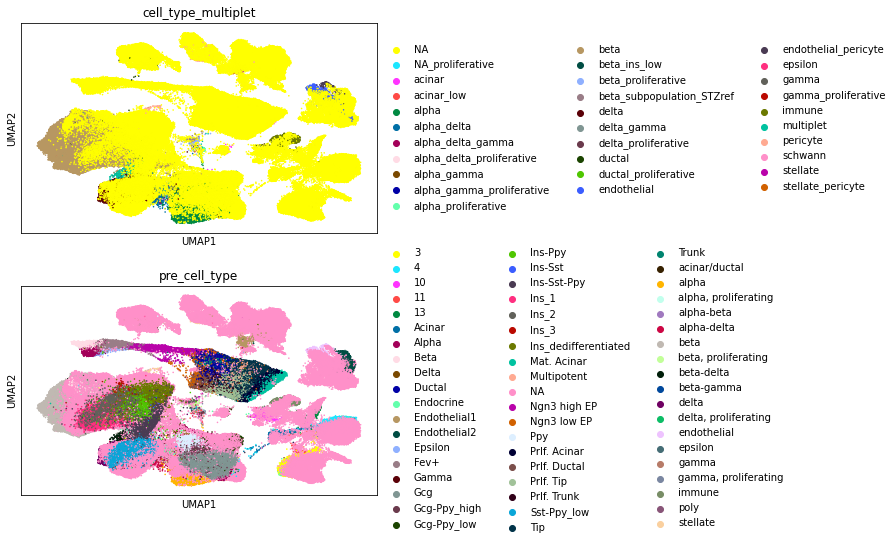

In [12]:
plot_obs=['cell_type_multiplet','pre_cell_type' ]
sc.pl.umap(adata_full,color=plot_obs,s=10,ncols=1)

In [13]:
print('\nAny missing (nan or NA):')
print('is nan')
print(adata_full.obs.columns[adata_full.obs.isna().any(axis=0)])
print('is NA')
print(adata_full.obs.columns[(adata_full.obs=='NA').any(axis=0)])


Any missing (nan or NA):
is nan
Index(['s_cyclone'], dtype='object')
is NA
Index(['pre_cell_type', 'cell_filtering', 'internal_id', 'cell_type',
       'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet'],
      dtype='object')


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


#C: One cell from spikein dataset is missing S phase score.

In [14]:
# Create raw-object (all genes) normalised data
adata_rawnorm=h.get_rawnormalised(adata_full,sf_col='size_factors_sample',use_log=True)

In [18]:
# Add genes used for integration annotation
used_genes=json.load(open(path_latent+'scArches.json','r'))['gene_names']
print("N genes used for integration:",len(used_genes))
adata_full.var['used_integration']=[True if gene in used_genes else False 
                                    for gene in adata_full.var.gene_symbol_original_matched]
print('N genes used for integration in created adata:',adata_full.var.used_integration.sum())

N genes used for integration: 2000
N genes used for integration in created adata: 2000


In [27]:
adata_rawnorm.var['used_integration']=[True if gene in used_genes else False 
                                    for gene in adata_rawnorm.var.gene_symbol_original_matched]
print('N genes used for integration in created rawnorm adata:',
      adata_rawnorm.var.used_integration.sum())

N genes used for integration in created rawnorm adata: 2000


In [35]:
adata_full.var.gene_symbol_original_matched[adata_full.var.used_integration].isna().sum()

0

#### Save rawnormalised object

In [31]:
adata_full

AnnData object with n_obs × n_vars = 301796 × 13999
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'pre_cell_type', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'design', 'strain', 'tissue', 'technique', 'internal_id', 'batch', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet'
    var: 'gene_symbol', 'used_integration', 'gene_symbol_original_matched'
    uns: 'cell_type_multiplet_colors', 'neighbors', 'pre_cell_type_colors', 'umap'
    obsm: 'X_integrated', 'X_umap'
    obsp: 'connectivities', 'distances'

In [32]:
adata_rawnorm

AnnData object with n_obs × n_vars = 301796 × 30672
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'pre_cell_type', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'design', 'strain', 'tissue', 'technique', 'internal_id', 'batch', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet'
    var: 'gene_symbol', 'used_integration', 'gene_symbol_original_matched'
    uns: 'cell_type_multiplet_colors', 'neighbors', 'pre_cell_type_colors', 'umap'
    obsm: 'X_integrated', 'X_umap'

In [36]:
adata_full.write(path_save+'data_integrated_annotated.h5ad')

... storing 'gene_symbol_original_matched' as categorical
... storing 'gene_symbol_original_matched' as categorical


In [37]:
adata_rawnorm.write(path_save+'data_rawnorm_integrated_annotated.h5ad')

... storing 'gene_symbol_original_matched' as categorical
